In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import statsmodels.api as stm

from sklearn.linear_model import LinearRegression

class Lowess:
    """ Simple class to provide a scikit-learn interface to statmodel's lowess"""
    def __init__(self, frac=0.1):
        assert 0 < frac < 1
        self.frac = frac

    def fit(self, x, y):
        assert len(x) == len(y)
        self.x = x
        self.y = y
        return self
        
    def predict(self, x=None):
        if x != None:
          raise NotImplementedError()
        prediction = stm.nonparametric.lowess(endog = self.y,
                                              exog = self.x,
                                              frac = self.frac,
                                              #xvals = x,
                                              is_sorted = False,
                                              return_sorted = False)
        ## do not assume that input is sorted (is_sorted=False is the default but good to be explicit)
        ## return_sorted==False ensures that output is returned in the original order if xvals==None
        return prediction

smoother = Lowess(frac = 0.125)

from google.colab import files 
## Upload 'Wednesday.csv' 
files.upload();

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving Wednesday.csv to Wednesday.csv


In [2]:
df = pd.read_csv("Wednesday.csv")
df["dissection_date"] = pd.to_datetime(df["dissection_date"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27284 entries, 0 to 27283
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       27284 non-null  int64         
 1   Age              27284 non-null  float64       
 2   Weight_kg        27284 non-null  float64       
 3   Height_cm        27284 non-null  float64       
 4   dissection_date  27284 non-null  datetime64[ns]
 5   AVD              27284 non-null  float64       
 6   txAVD            27284 non-null  float64       
 7   PVD              17795 non-null  float64       
 8   Id               27284 non-null  int64         
 9   Sex              27284 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 2.1+ MB


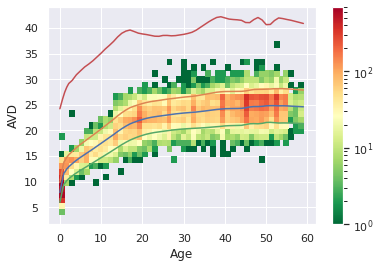

In [4]:
## plot 2d histogram of AVD against Age
sns.histplot(df, x="Age", y="AVD", bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )

## fit a lowess curve to AVD vs Age, and plot over the 2d histogram.
## The plt.plot function connects points in the order you give them, so they need to be sorted.
## (You could also choose to plot points, not lines; as the data is very dense this gives the same effect)
df = df.sort_values('Age')   ## so that we can plot a curve
smoother.fit(df['Age'], df['AVD'])
df.loc[:,'AVD_lowess'] = smoother.predict()
plt.plot( df['Age'], df['AVD_lowess'] )

## compute the residuals and store as a new column in the dataframe; then fit a smooth function to the squared residual
## (i.e. the local variance), and plot the mean +- twice the standard deviation.  Also plot the standard deviation
## (scaled to show it in the plot)
df['AVD_resid'] = df['AVD'] - df['AVD_lowess']
smoother.fit(df['Age'], df['AVD_resid'] * df['AVD_resid'] )
df['AVD_sd'] = np.sqrt(smoother.predict())
plt.plot( df['Age'], df['AVD_lowess'] + 2*df['AVD_sd'] )
plt.plot( df['Age'], df['AVD_lowess'] - 2*df['AVD_sd'] )
plt.plot( df['Age'], 25*df['AVD_sd'] )

plt.show()

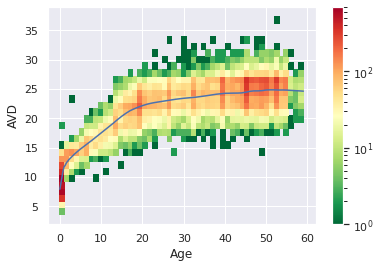

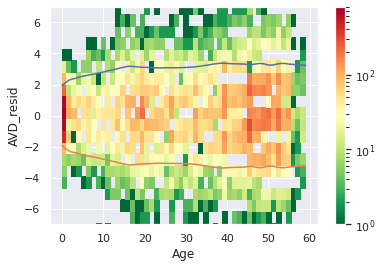

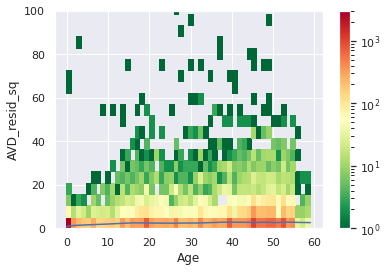

In [5]:
sns.histplot(df, x="Age", y="AVD", bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
smoother.fit(df["Age"], df["AVD"])
plt.plot( df["Age"], smoother.predict())
plt.show()

smoother2 = Lowess(frac = 0.12)

df["AVD_resid"] = df["AVD"] - smoother.predict()
df["AVD_resid_sq"] = df["AVD_resid"] * df["AVD_resid"]
smoother2.fit(df["Age"], df["AVD_resid_sq"])

sns.histplot(df, x="Age", y="AVD_resid", bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
plt.plot( df["Age"], 2*np.sqrt(smoother2.predict()))
plt.plot( df["Age"], -2*np.sqrt(smoother2.predict()))
plt.ylim((-7,7))
plt.show()

sns.histplot(df, x="Age", y="AVD_resid_sq", bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
smoother.fit(df["Age"], df["AVD_resid_sq"])
plt.plot( df["Age"], smoother2.predict())
plt.ylim((0,100))
plt.show()


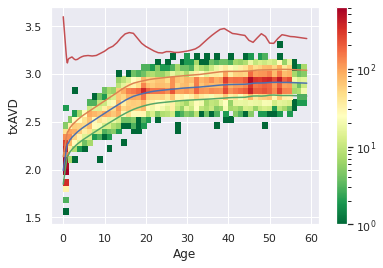

In [6]:
df['txAVD'] = np.power(df['AVD'], 0.333)

# an alternative transformation that works just as well
#df['txAVD'] = np.log(df['AVD'] + 10)

xvar = "Age"
yvar = "txAVD"

sns.histplot(df, x=xvar, y=yvar, bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )

smoother.fit(df[xvar], df[yvar])
df[yvar+'_lowess'] = smoother.predict()
df = df.sort_values(xvar)   ## so that we can plot a curve
plt.plot( df[xvar], df[yvar+'_lowess'] )

df[yvar+'_resid'] = df[yvar] - df[yvar+'_lowess']
smoother.fit(df[xvar], df[yvar+'_resid'] * df[yvar+'_resid'] )
df[yvar+'_sd'] = np.sqrt(smoother.predict())
plt.plot( df[xvar], df[yvar+'_lowess'] + 2*df[yvar+'_sd'] )
plt.plot( df[xvar], df[yvar+'_lowess'] - 2*df[yvar+'_sd'] )
plt.plot( df[xvar], 50*df[yvar+'_sd'] )

plt.show()

In [8]:
## encode Sex, 0=male, 1=female
#df['male'] = (df['Sex'] == "male").astype('float')
#df = df.drop("Sex", axis=1)

## do the same, but with Pandas functions  (note, column is called 'male' now)
df = df.join(pd.get_dummies(df['Sex'], drop_first = True))
df = df.drop("Sex",axis=1)

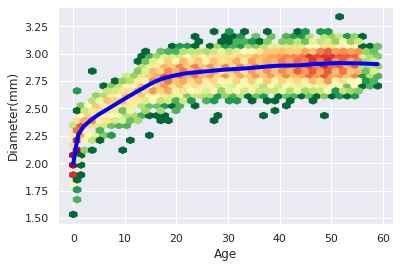

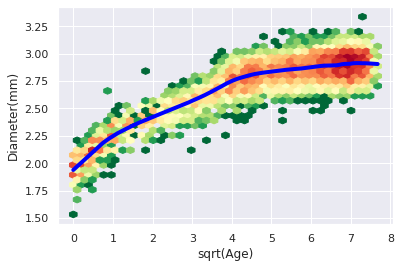

In [9]:
## Show need for variable transformation - (tx)AVD depends strongly on Age for children

plt.hexbin(x=df.Age, y=df.txAVD, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), gridsize=(40,20), mincnt=1)
smoother.fit(df['Age'], df['txAVD'])
plt.plot(df['Age'], smoother.predict(), color="blue", linewidth=4)
plt.xlabel("Age")
plt.ylabel("Diameter(mm)")
plt.show()

## a sqrt transformation makes the curve much smoother near age 0
plt.hexbin(x=np.sqrt(df.Age), y=df.txAVD, gridsize=(40,20), mincnt=1,
           cmap="RdYlGn_r", norm=mpl.colors.LogNorm())
smoother.fit(np.sqrt(df['Age']), df['txAVD'])
plt.plot(np.sqrt(df['Age']), smoother.predict(), color="blue", linewidth=4)
plt.xlabel("sqrt(Age)")
plt.ylabel("Diameter(mm)")
plt.show()

In [10]:
Xlin = df[["Age","Weight_kg","Height_cm"]]
y = df[["txAVD"]]

model = LinearRegression()
model.fit(Xlin,y)
print("Age: R2 = ",model.score(Xlin,y))

df["sqrtAge"] = np.sqrt(df["Age"])

Xsqrt = df[["sqrtAge","Weight_kg","Height_cm"]]
model.fit(Xsqrt, y)
print("sqrt Age: R2 = ",model.score(Xsqrt,y))


Age: R2 =  0.9140655466316444
sqrt Age: R2 =  0.9191800989151294


In [16]:
## Build a pipeline, and make the exponent of the transformation for Age a parameter

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class PowerTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, exponent=1.0):
        self.exponent = exponent
        
    def fit(self, X, y=None):
        return self            ## no parameters need to be fit - so just return
    
    def transform(self, X):
        return np.power(X, self.exponent)
    
    def inverse_transform(self, X):
        return np.power(X, 1.0 / self.exponent)

age_exponent = 0.5
    
## This applies different transformers to each column.  
## Parameter is a list of tuples:  (name, transformer, list-of-column-names)
##   Special value 'passthrough' for transformer just lets the data through unchanged
##   If parameter 'remainder' is set to 'passthrough', alll unnamed columns are let through unchanged
ct = ColumnTransformer(
                       [("power_tx_age",  PowerTransformer(age_exponent), ["Age"]),
                        ("identity",      "passthrough",                  ["Weight_kg","Height_cm"])
                       ],
                       remainder = "drop"
                      )

## Build a pipeline - just two steps
pipe = Pipeline([('transform', ct),
                 ('model', LinearRegression())])

## Show the parameters.  We can ignore most of them
## The one we're interested in later on is transform__power_tx_age__exponent
pipe.get_params()

{'memory': None,
 'model': LinearRegression(),
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__n_jobs': None,
 'model__normalize': 'deprecated',
 'model__positive': False,
 'steps': [('transform',
   ColumnTransformer(transformers=[('power_tx_age', PowerTransformer(exponent=0.5),
                                    ['Age']),
                                   ('identity', 'passthrough',
                                    ['Weight_kg', 'Height_cm'])])),
  ('model', LinearRegression())],
 'transform': ColumnTransformer(transformers=[('power_tx_age', PowerTransformer(exponent=0.5),
                                  ['Age']),
                                 ('identity', 'passthrough',
                                  ['Weight_kg', 'Height_cm'])]),
 'transform__identity': 'passthrough',
 'transform__n_jobs': None,
 'transform__power_tx_age': PowerTransformer(exponent=0.5),
 'transform__power_tx_age__exponent': 0.5,
 'transform__remainder': 'drop',
 'transform__sparse_thre

In [17]:
y = df['txAVD']
X = df           ## We don't have to select columns now, ColumnTransformer does that
pipe.fit( X, y )

## One way to get components of the pipeline, is by their name, via the named_steps function.
## Extract the last component (the model) and print its coefficients
## (Note that estimed or fitted attributes have a trailing underscore)
print( "Coefficients: ",pipe.named_steps['model'].coef_)
print( "Intercept: ",pipe.named_steps['model'].intercept_)
print( "Model's default score (r2): ",pipe.score( X, y ))

## Now set the exponent to 1 - no transformation - and see what this does to model performance
## (It deteriorates)

pipe.set_params(transform__power_tx_age__exponent = 1.0)

pipe.fit( X, y )

print( "-----\n Using  age  rather than  sqrt(age):\n-----")
print( "Coefficients: ",pipe.named_steps['model'].coef_)
print( "Intercept: ",pipe.named_steps['model'].intercept_)
print( "Model's default score (r2): ",pipe.score( X, y ))

Coefficients:  [0.04002335 0.00064508 0.00414457]
Intercept:  1.8471441206035273
Model's default score (r2):  0.9191800989151294
-----
 Using  age  rather than  sqrt(age):
-----
Coefficients:  [0.00327136 0.00065526 0.00492833]
Intercept:  1.8275824893929373
Model's default score (r2):  0.9140655466316444


In [18]:
def Make_safe_r2_scorer(y):

    avg = np.average(y)
    mean_sumsq = np.average( (y-avg) * (y-avg) ) 
    
    def safe_r2_scorer(estimator, X, y):
        ypred = estimator.predict( X )
        residuals = y - ypred
        resid_sumsq = np.average(residuals * residuals)
        ## Compare residual sum of squares of the data X, y, with the sum of squared 
        ## differences to the mean for the *full* data set.  This makes the r2 values
        ## average out to a sensible value.
        r2 = 1 - resid_sumsq / mean_sumsq
        return r2
        
    ## The returned function has "bound" the variable mean_sumsq, which is now
    ## available whenever someone calls safe_r2_scorer
    return safe_r2_scorer

safe_r2_scorer = Make_safe_r2_scorer( y )

print ( "Safe r2 score: ", safe_r2_scorer(pipe, X, y))  ## the same, as all data used - but stable for small folds

Safe r2 score:  0.9140655466316444


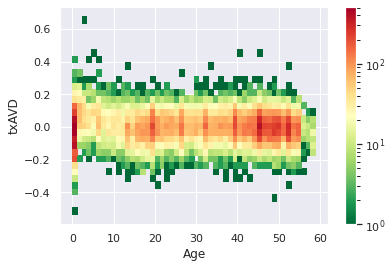

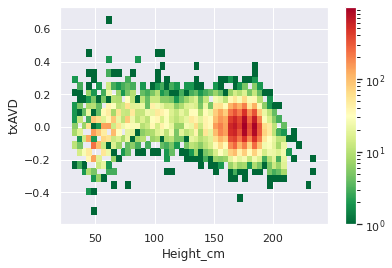

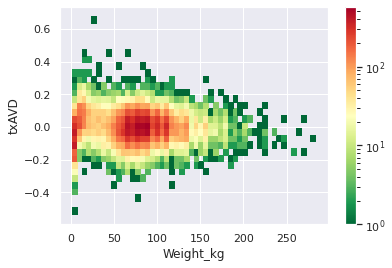

In [19]:
## Use 'predict' on the training data and plot residuals - just to see if it's all behaving sensibly

pred = pipe.predict( df )

sns.histplot(df, x="Age", y=y-pred, bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
plt.show()
sns.histplot(df, x="Height_cm", y=y-pred, bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
plt.show()
sns.histplot(df, x="Weight_kg", y=y-pred, bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )


In [22]:
## Assessing the model on training data is a bad idea
## Let's use cross validation.  Test scores are indeed a little worse
## The difference is small in this case - it's a simple model, and a large data set

scoremethod = safe_r2_scorer
#scoremethod = "r2"                        ## Don't use this -- it gives unstable results, esp. for small folds
#scoremethod = "neg_mean_squared_error"    ## This one works fine -- but numbers are a bit more difficult to interpret

## (To see why the safe R2 score is necessary, try replacing the "score" item with the string "r2") 
##  Another safe alternative is to use "neg_mean_squared_error", but those numbers are less easily
##  interpretable.)

from sklearn.model_selection import cross_validate

## Just a helper function to print the results
def cv_summary(scores):
    return "{:1.5f} +- {:1.5f}".format( scores.mean(), scores.std() )

y = df['txAVD']
X = df

pipe.set_params(transform__power_tx_age__exponent = 1.0)  ## This is now just a linear model

result = cross_validate(pipe, X, y, cv=5, scoring={"score": scoremethod}, return_train_score=True)
print( "Linear(Age): Training scores (cv): ",cv_summary( result['train_score']))
print( "Linear(Age): Test scores (cv): ",cv_summary( result['test_score']) ) 

## Just to show that this is just a linear model.  We do have to select the variables
Xlin = X[["Age","Height_cm","Weight_kg"]]
lin_model = LinearRegression()

result = cross_validate(lin_model, Xlin, y, cv=5, scoring={"score": scoremethod}, return_train_score=True)
print( "Linear(Age): Training scores (cv): ",cv_summary( result['train_score']))
print( "Linear(Age): Test scores (cv): ",cv_summary( result['test_score']) ) 

## Now use the sqrt transformation
pipe.set_params(transform__power_tx_age__exponent = 0.5)

result = cross_validate(pipe, X, y, cv=5, scoring={"score": scoremethod}, return_train_score=True)
print( "Linear(sqrt Age): Training scores (cv): ",cv_summary( result['train_score']))
print( "Linear(sqrt Age): Test scores (cv): ",cv_summary( result['test_score']) ) 

Linear(Age): Training scores (cv):  0.91475 +- 0.00731
Linear(Age): Test scores (cv):  0.87176 +- 0.10334
Linear(Age): Training scores (cv):  0.91475 +- 0.00731
Linear(Age): Test scores (cv):  0.87176 +- 0.10334
Linear(sqrt Age): Training scores (cv):  0.91938 +- 0.00519
Linear(sqrt Age): Test scores (cv):  0.90981 +- 0.03560


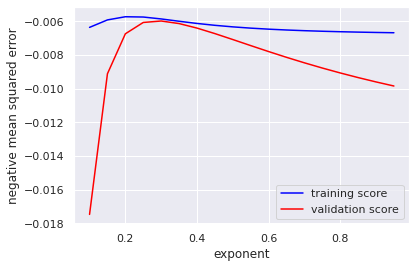

In [23]:
from sklearn.model_selection import validation_curve

scoremethod = 'neg_mean_squared_error'   ## or safe R2 - but not the default, r2
#scoremethod = safe_r2_scorer

exponents = np.arange(0.1, 1.0, 0.05)
train_score, val_score = validation_curve(pipe, X, y,
                                          param_name = 'transform__power_tx_age__exponent', 
                                          param_range = exponents, 
                                          cv = 5,
                                          scoring = scoremethod)

plt.plot(exponents, np.mean (train_score, 1), color='blue', label='training score')
plt.plot(exponents, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('exponent')
plt.ylabel('negative mean squared error');